In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, MultiHeadAttention, Flatten, Add, GRU, Lambda, Reshape
from tensorflow.keras.optimizers import Adam

In [4]:
# Load the dataset
file_path = "ModDatasets/ALSRiluFamily.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: File '{file_path}' not found.")

df = pd.read_csv(file_path)

C:\Users\Hema Vignesh\AppData\Local\Temp\ipykernel_24736\48469853.py:6: DtypeWarning: Columns (18,19,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
# Data Preprocessing
print("Initial Data Shape:", df.shape)

Initial Data Shape: (72004, 60)


In [6]:
# Handle Missing Values
missing_percentage = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percentage[missing_percentage > 80].index
df.drop(columns=columns_to_drop, inplace=True)
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].median(), inplace=True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop_duplicates(inplace=True)

C:\Users\Hema Vignesh\AppData\Local\Temp\ipykernel_24736\3749386073.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [7]:
# Feature Scaling
numerical_features = df.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [8]:
# Ensure ALSFRS_Delta is sorted properly before splitting
df_sorted = df.sort_values(['subject_id', 'ALSFRS_Delta'])

In [9]:
# Train-Test Split (Time-Based)
train_size = int(0.7 * len(df_sorted))
val_size = int(0.15 * len(df_sorted))
test_size = len(df_sorted) - train_size - val_size

train_df = df_sorted.iloc[:train_size]
val_df = df_sorted.iloc[train_size:train_size + val_size]
test_df = df_sorted.iloc[train_size + val_size:]

In [10]:
# Convert DataFrames to NumPy arrays
X_train, y_train = train_df[numerical_features].values, train_df['ALSFRS_Delta'].values
X_val, y_val = val_df[numerical_features].values, val_df['ALSFRS_Delta'].values
X_test, y_test = test_df[numerical_features].values, test_df['ALSFRS_Delta'].values

In [11]:
# Reshape input for Transformer Model (batch, sequence_length, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Data Types:
subject_id                         float64
Q1_Speech                          float64
Q2_Salivation                      float64
Q3_Swallowing                      float64
Q4_Handwriting                     float64
Q5a_Cutting_without_Gastrostomy    float64
Q6_Dressing_and_Hygiene            float64
Q7_Turning_in_Bed                  float64
Q8_Walking                         float64
Q9_Climbing_Stairs                 float64
Q10_Respiratory                    float64
ALSFRS_Delta                       float64
ALSFRS_Total                       float64
ALSFRS_R_Total                     float64
R_1_Dyspnea                        float64
R_2_Orthopnea                      float64
R_3_Respiratory_Insufficiency      float64
Subject_used_Riluzole               object
Riluzole_use_Delta                 float64
dtype: object

Number of Unique Values:
subject_id                         11442
Q1_Speech                              9
Q2_Salivation                          9
Q3_Swall

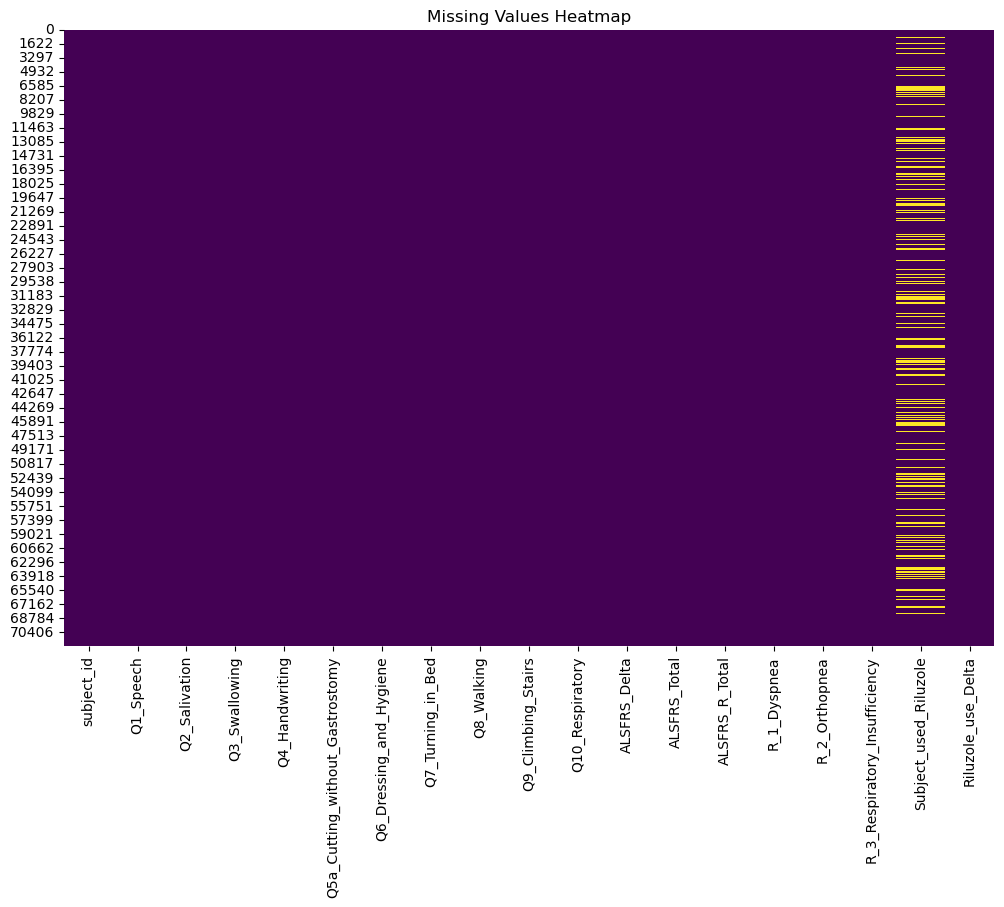

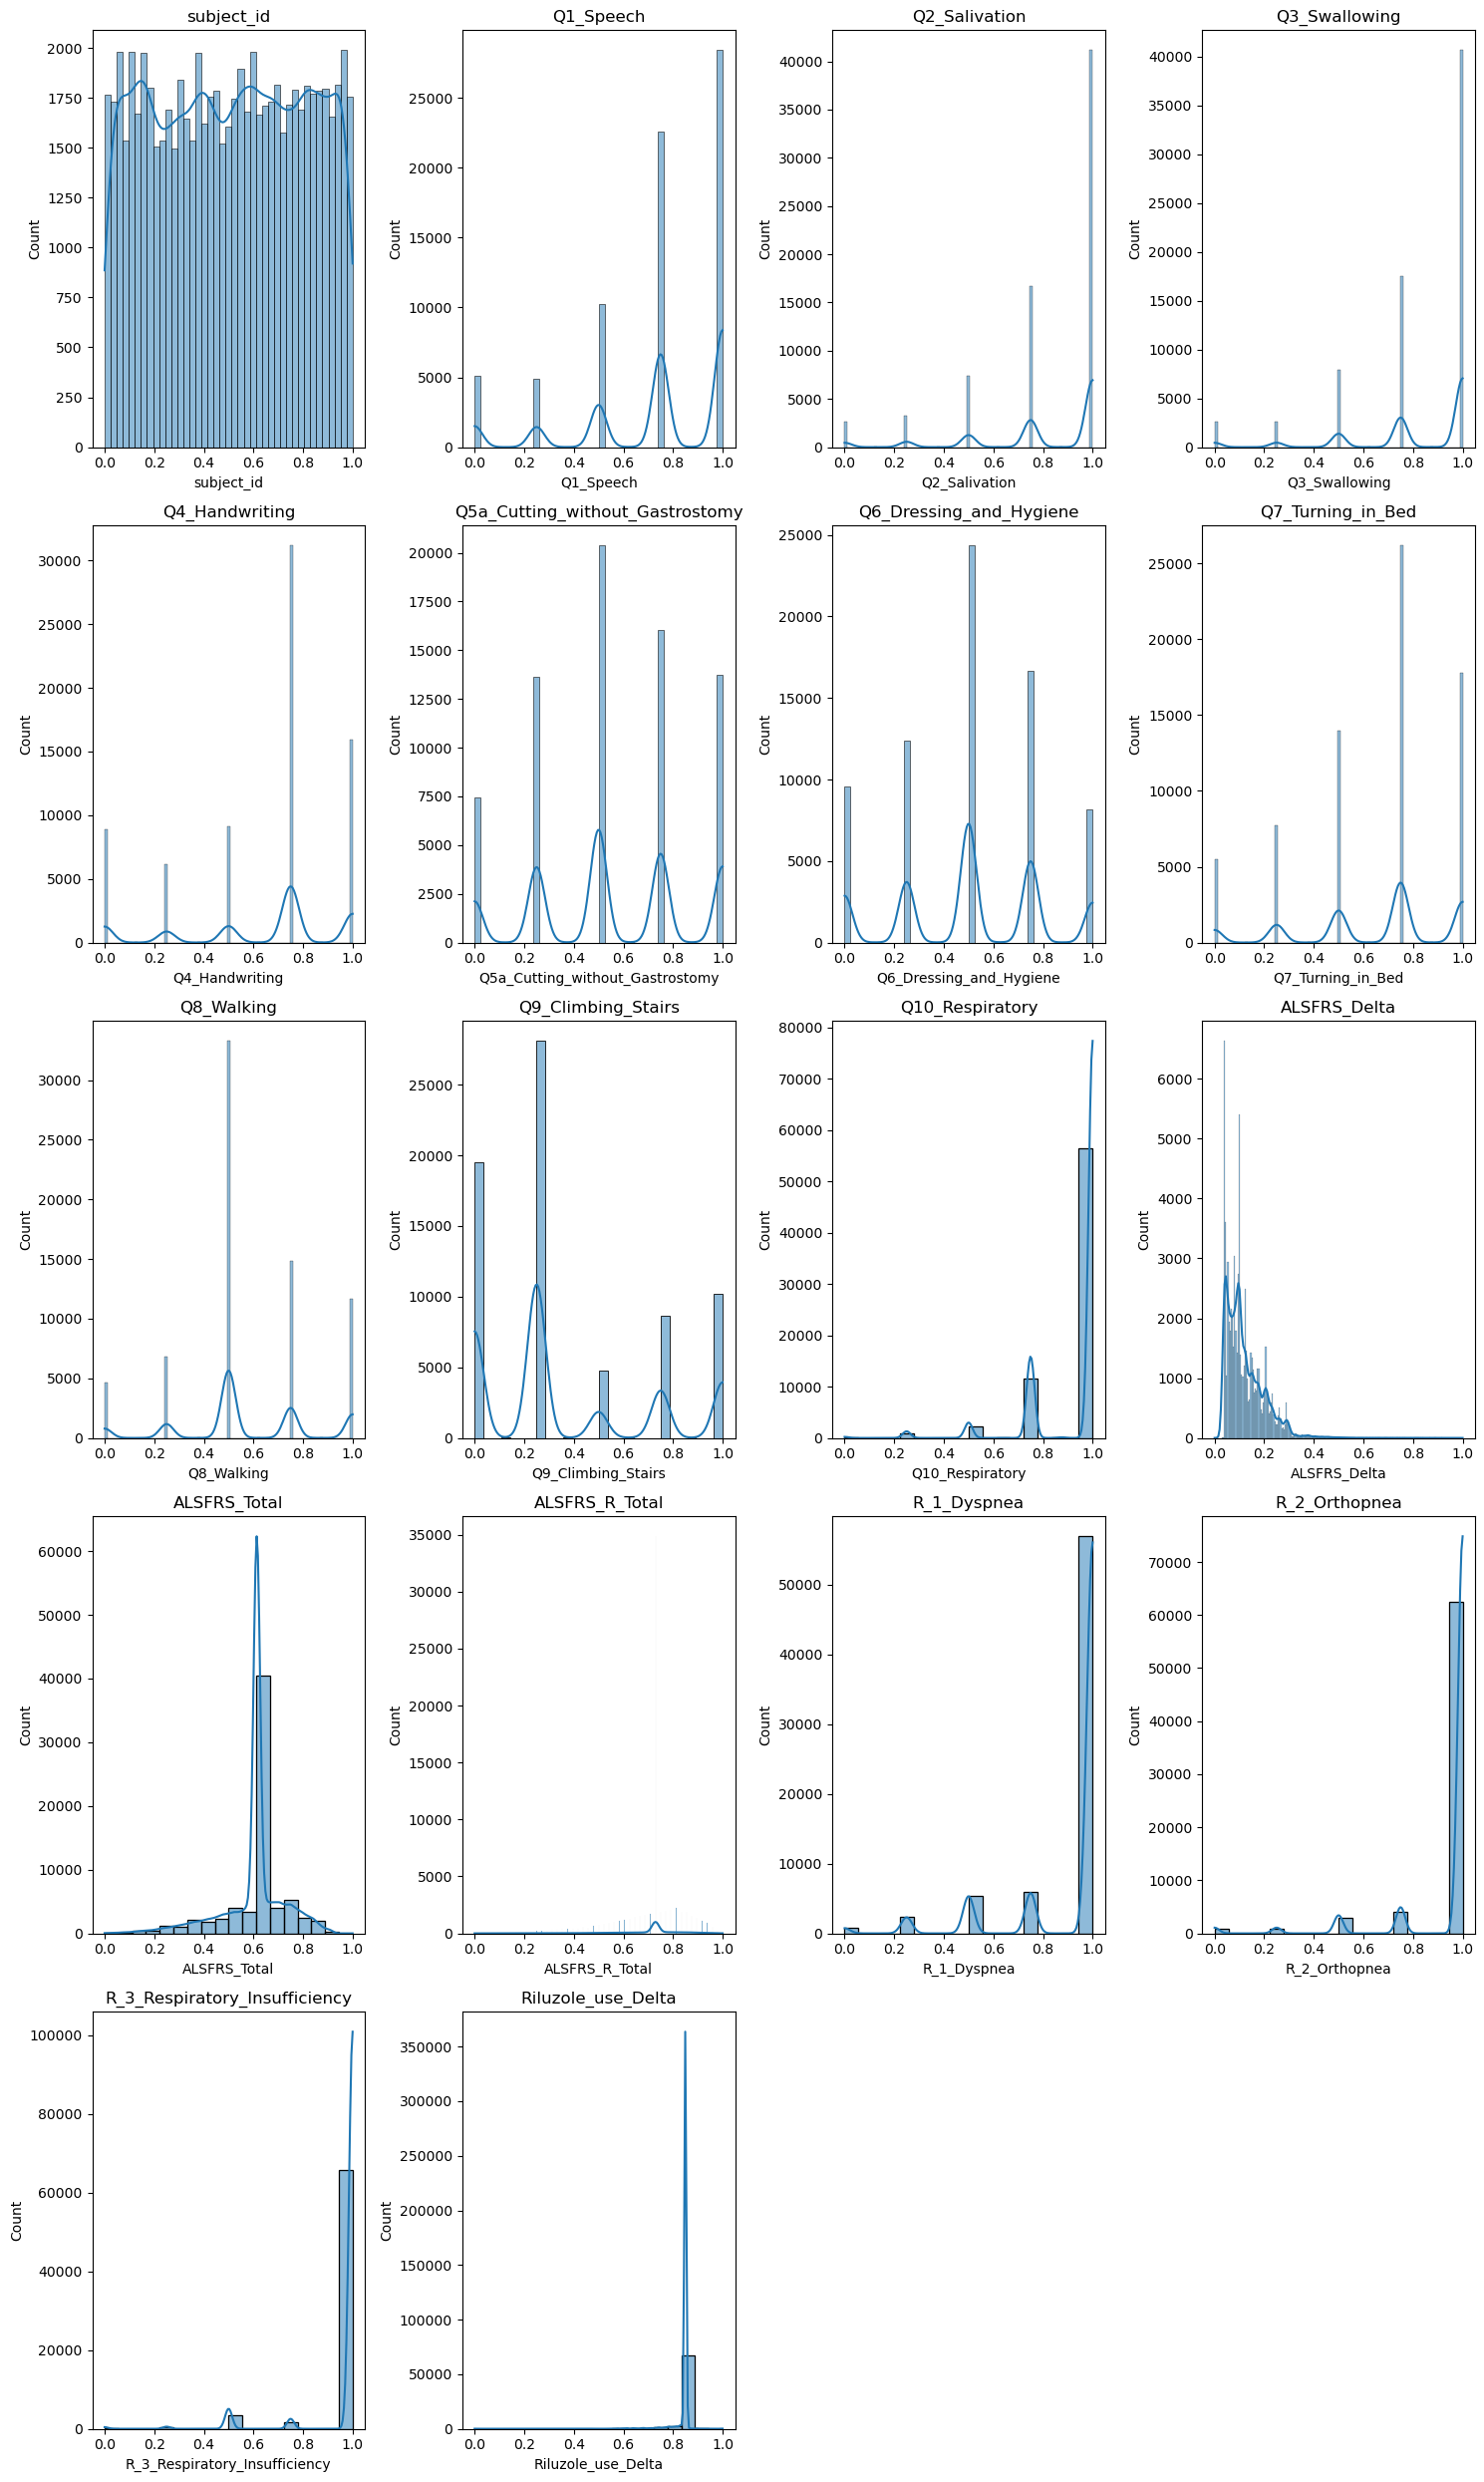

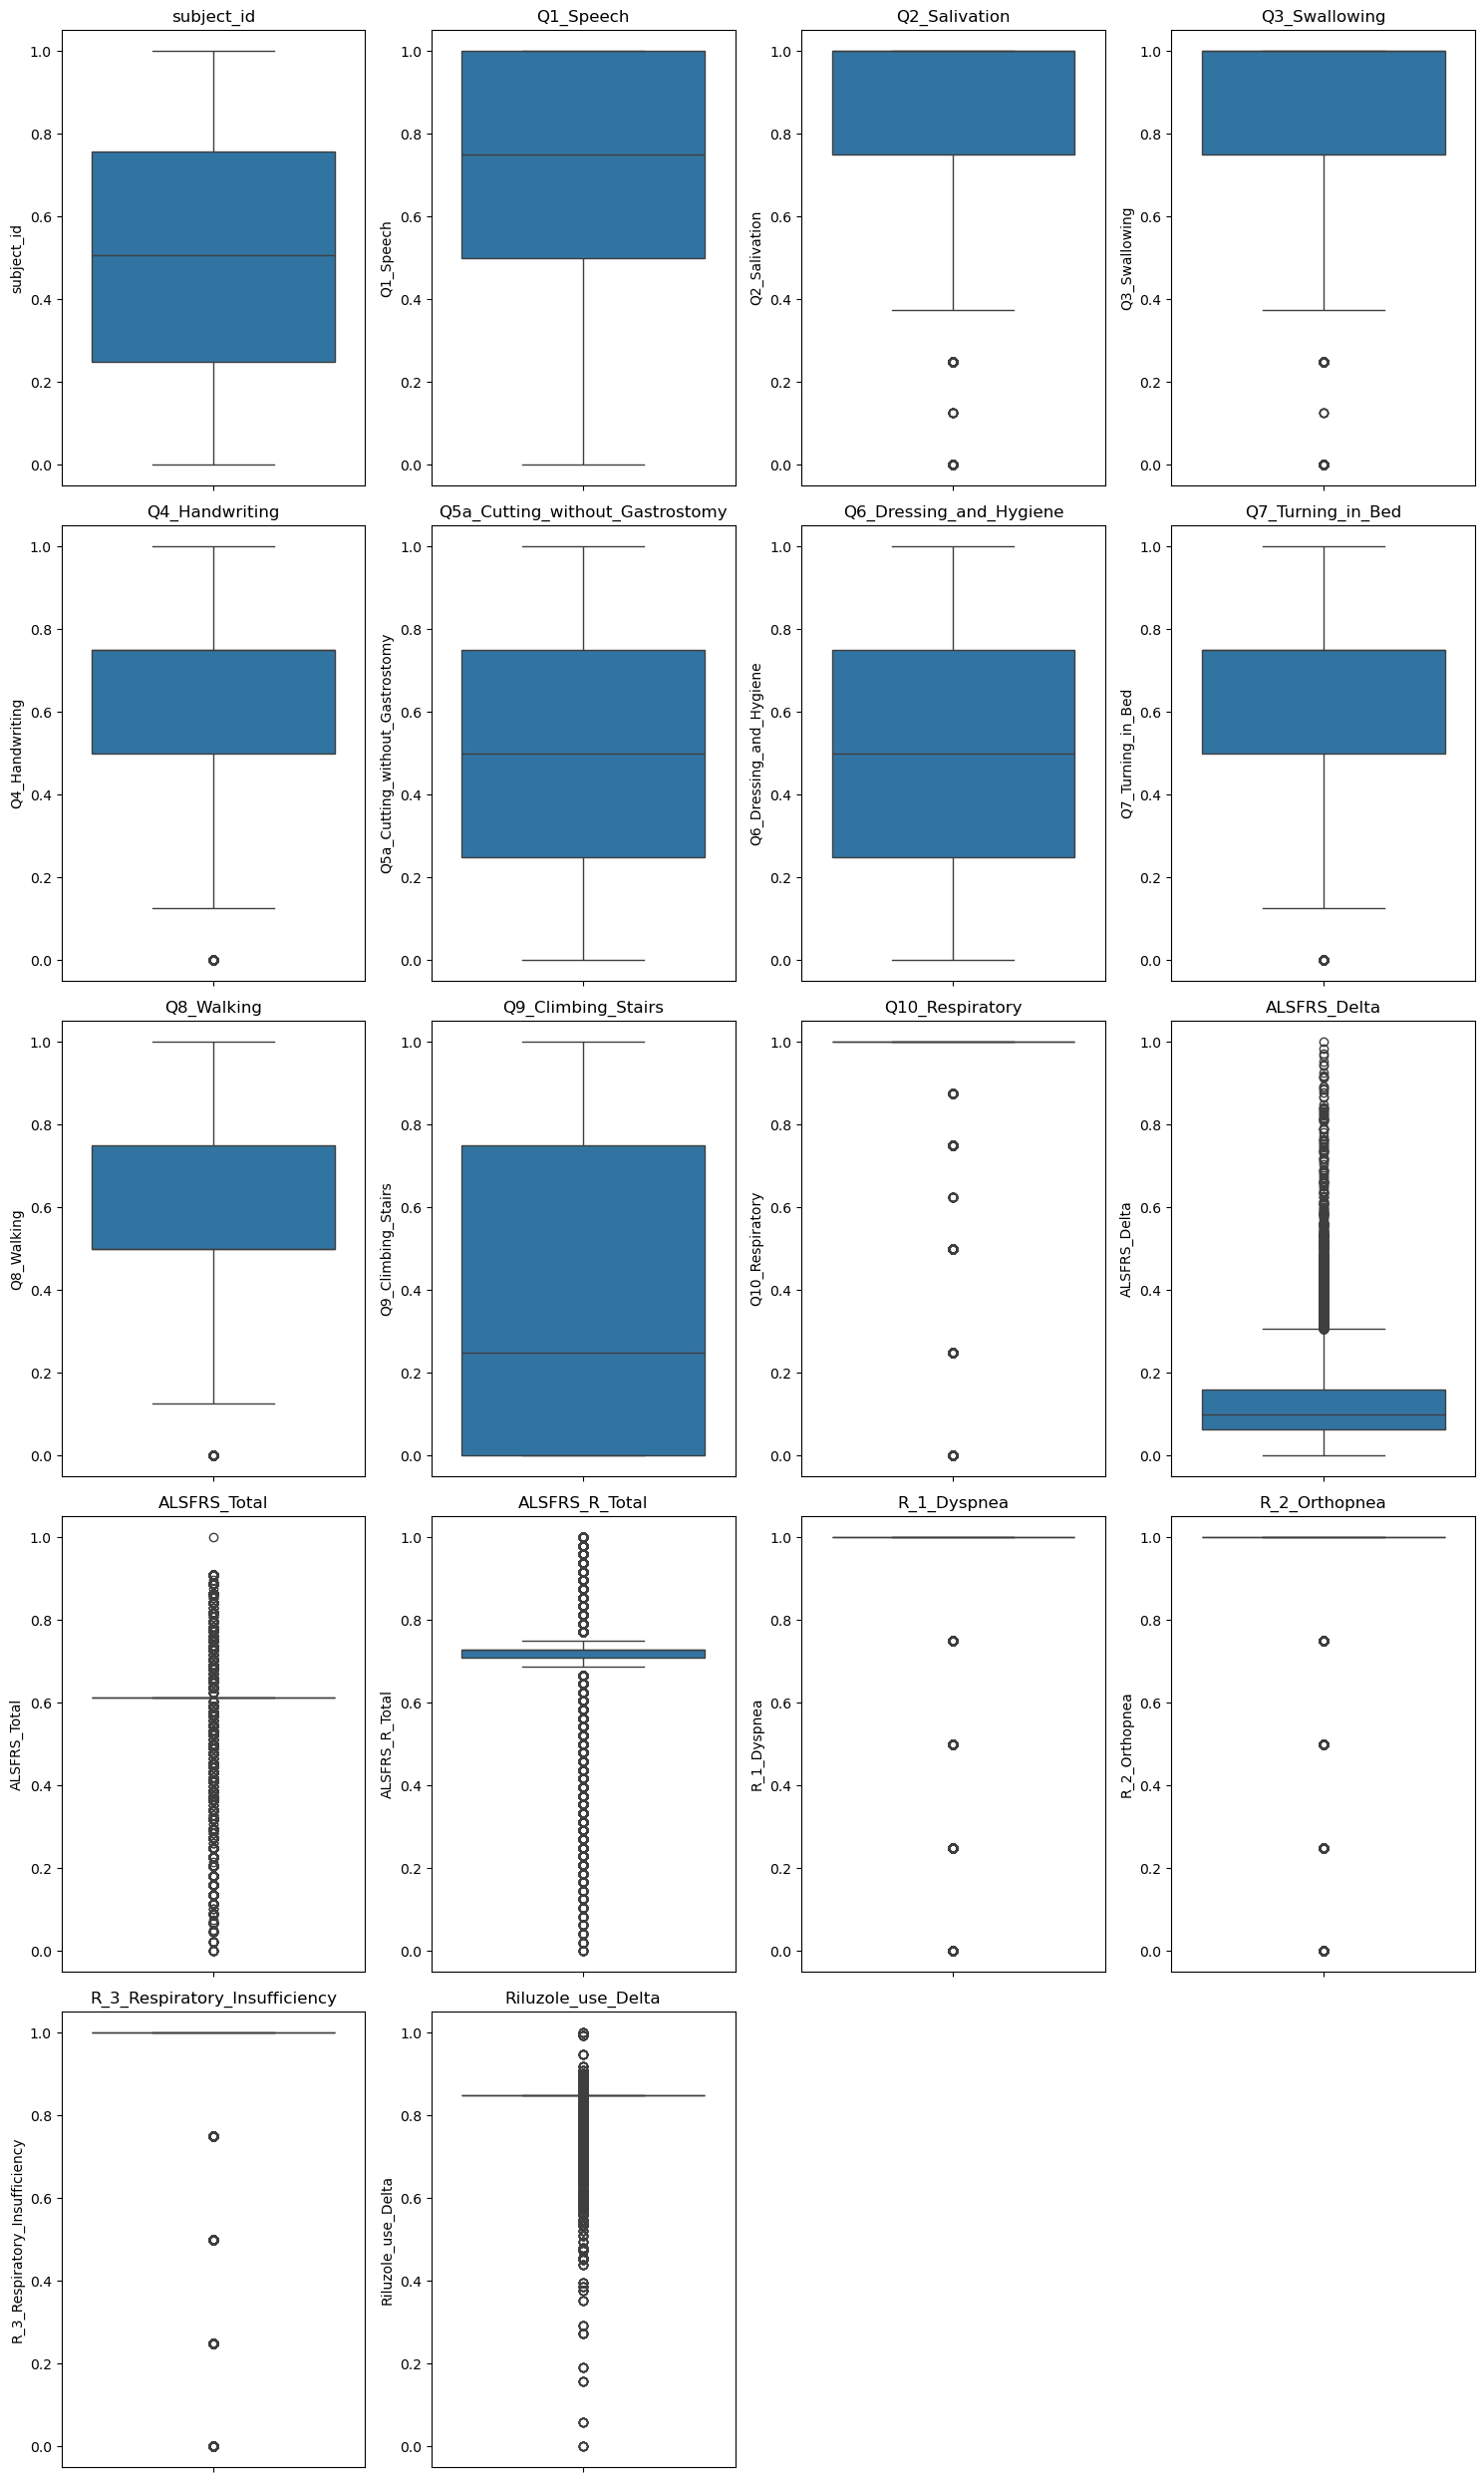

Proposed strategy for handling missing values:
Further investigation is needed to determine the best approach. Imputation strategies, such as mean/median imputation or more sophisticated methods, could be considered. Removal of rows or columns with high missing value percentages could also be an option.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Overview
print("Data Types:")
print(df.dtypes)
print("\nNumber of Unique Values:")
print(df.nunique())
print("\nNull Value Counts:")
print(df.isnull().sum())

# 2. Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe(include='all'))

# 3. Missing Values Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# 4. Distribution Analysis
numerical_cols = df.select_dtypes(include=['number']).columns
num_numerical_cols = len(numerical_cols)
# Calculate the number of rows and columns for subplots
n_rows = (num_numerical_cols + 3) // 4  # Ensure enough rows
n_cols = min(num_numerical_cols, 4)

plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure height based on the number of rows
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Box plots for outliers
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


print("Proposed strategy for handling missing values:")
print("Further investigation is needed to determine the best approach. Imputation strategies, such as mean/median imputation or more sophisticated methods, could be considered. Removal of rows or columns with high missing value percentages could also be an option.")

In [13]:
# Define Memory Slots
MEMORY_SIZE = 10  # Number of memory slots
MEMORY_DIM = 64   # Size of each memory slot

In [14]:
# Memory Initialization within Model
def init_memory(x):
    batch_size = tf.shape(x)[0]
    return tf.random.normal((batch_size, MEMORY_SIZE, MEMORY_DIM))

input_layer = Input(shape=(1, len(numerical_features)))
normalized = LayerNormalization()(input_layer)

In [15]:
# Initialize Memory Properly
memory = Lambda(init_memory, name="memory_init")(input_layer)

In [16]:
# Self-attention over memory slots
memory_attention = MultiHeadAttention(num_heads=4, key_dim=MEMORY_DIM)(memory, memory, memory)
updated_memory = Add()([memory, memory_attention])

In [17]:
# Memory Read Mechanism
read_memory = MultiHeadAttention(num_heads=4, key_dim=MEMORY_DIM)(normalized, updated_memory, updated_memory)
add_1 = Add()([read_memory, normalized])

In [18]:
# Memory Update via Gated Mechanism
memory_expanded = Reshape((MEMORY_SIZE, MEMORY_DIM))(updated_memory)
gru_memory = GRU(MEMORY_DIM, return_sequences=False, activation='relu')(memory_expanded)
memory_gate = Dense(MEMORY_DIM, activation='sigmoid')(gru_memory)
updated_memory = Add()([gru_memory, memory_gate])

In [19]:
# Flatten and Fully Connected Layers
flattened = Flatten()(add_1)
dense1 = Dense(256, activation='relu')(flattened)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)
dense3 = Dense(64, activation='relu')(dropout2)
dropout3 = Dropout(0.3)(dense3)
output_layer = Dense(1)(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)

In [20]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=['mae'])

In [21]:
# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=64, verbose=1)

Epoch 1/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0946 - mae: 0.0946 - val_loss: 0.0488 - val_mae: 0.0488
Epoch 2/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0436 - val_mae: 0.0436
Epoch 3/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0405 - val_mae: 0.0405
Epoch 4/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 5/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 6/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 7/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0246 - val_mae: 0.0246
Epoch 8/150
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 9/150
781/781 ━━━━━━━━━━━━

In [22]:
# Save the Model
model.save('als_progression_rmt_model.h5')

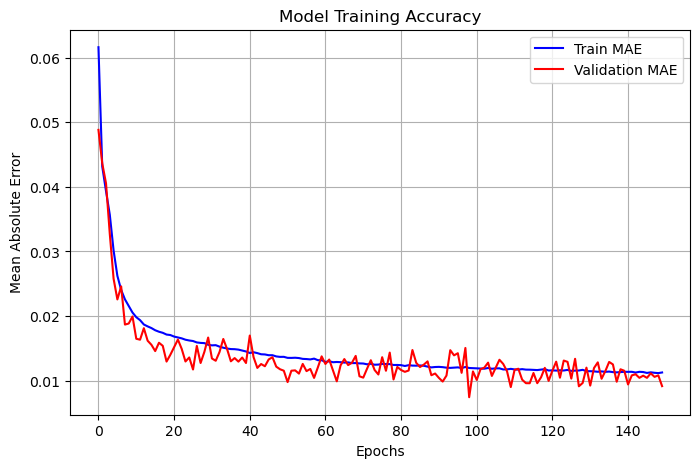

In [23]:
# Plot Training Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Model Training Accuracy')
plt.grid(True)
plt.show()

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


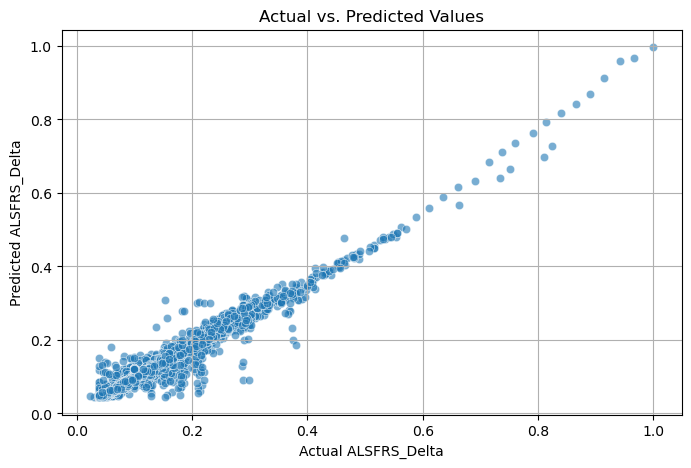

In [24]:
# Predicted vs. Actual Values
y_pred = model.predict(X_test)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.6)
plt.xlabel('Actual ALSFRS_Delta')
plt.ylabel('Predicted ALSFRS_Delta')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [25]:
# Function to Convert MAE to Accuracy
def mae_to_accuracy(mae, y_actual):
    target_range = y_actual.max() - y_actual.min()
    accuracy = 100 - ((mae / target_range) * 100)
    return max(0, min(accuracy, 100))

train_mae = history.history['mae'][-1]
val_mae = history.history['val_mae'][-1]
train_accuracy = mae_to_accuracy(train_mae, y_train)
val_accuracy = mae_to_accuracy(val_mae, y_val)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Training Accuracy: 98.84%
Validation Accuracy: 98.92%
